In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from calendar import monthrange
from glob import glob
import pickle
import geopandas
from shapely.geometry import Point

In [2]:
truth_dir = '/scratch/alpine/mecr8410/semantic_segmentation_smoke/filtered_data/truth/'
sample_counts = pd.DataFrame({'Light' : [0, 0, 0, 0, 0, 0],
                              'Medium': [0, 0, 0, 0, 0, 0],
                              'Heavy' : [0, 0, 0, 0, 0, 0]},
                             index=['2018', '2019', '2020', '2021', '2022', '2023'])
for yr in sample_counts.index:
    for density in list(sample_counts):
        num_samples =  len(os.listdir("{}{}/{}/".format(truth_dir, yr, density)))
        sample_counts.loc[yr, density] = num_samples
print(sample_counts)

      Light  Medium  Heavy
2018  20415    3841   1955
2019  19414    4993   2587
2020  21944    6305   3334
2021  11780    4282   3176
2022   9173    4481   2155
2023   8084    4121   2460


Text(0, 0.5, 'Sample Counts')

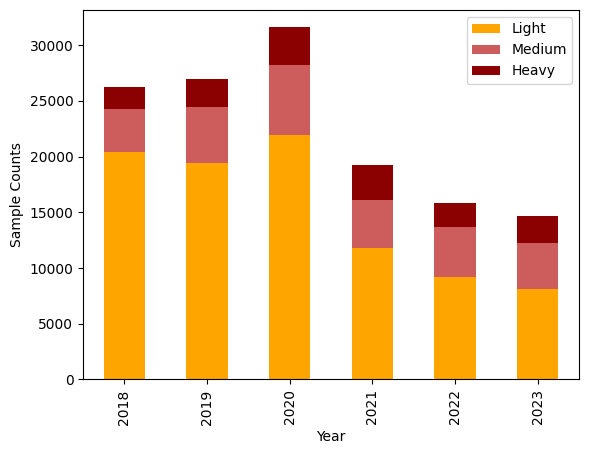

In [3]:
sample_counts.plot(kind='bar', stacked=True, color=['orange', 'indianred', 'darkred'])
plt.xlabel('Year')
plt.ylabel('Sample Counts')

In [4]:
month_counts = pd.DataFrame({'2018' : [0]*12, '2019' : [0]*12, '2020' : [0]*12, '2021' : [0]*12, '2022' : [0]*12, '2023' : [0]*12},
                             index = list(range(1,13)))
for yr in list(month_counts):
    curr_dn = 0
    for month in month_counts.index:
        days = monthrange(int(yr), int(month))
        for day in range(1,days[1]+1):
            curr_dn += 1
            dn_str = str(curr_dn).zfill(3)
            num_dn_samples =  len(glob("{}{}/*/G1*_s{}{}*tif".format(truth_dir, yr, yr, dn_str)))
            month_counts.loc[month, yr] += num_dn_samples

In [5]:
month_counts

,2018,2019,2020,2021,2022,2023
1,2012,1444,5181,1830,1901,1602
2,831,1282,7414,2316,1720,2227
3,4851,3580,9936,5304,2528,3681
4,4808,3710,8926,5961,1844,2099
5,2291,2810,7661,3515,1075,1823
6,1740,1061,5241,2983,898,2094
7,1856,1609,5421,3275,705,1219
8,2040,2050,6496,2483,1224,1487
9,1809,2543,3601,1600,1016,1698
10,2111,2844,5221,1893,1886,2559


Text(0, 0.5, 'Sample Counts')

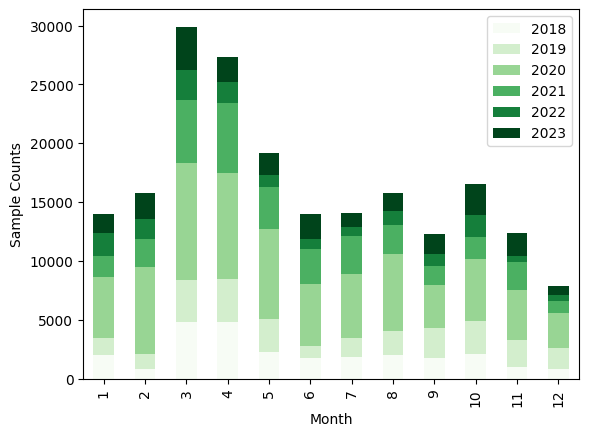

In [6]:
month_counts.plot(kind='bar', stacked=True, cmap='Greens')
plt.xlabel('Month')
plt.ylabel('Sample Counts')

In [7]:
lat_lon_pkl = '/projects/mecr8410/SmokeViz_code/deep_learning/dataset_pointers/geo_dependent/dict_lat_lon_fn.pkl'
with open(lat_lon_pkl, 'rb') as handle:
    lat_lon_dict = pickle.load(handle)
states = geopandas.read_file('./shape_files/states.shp')
countries = geopandas.read_file('./shape_files/NA_countries.shp')

df = pd.DataFrame(lat_lon_dict)
geometry= geopandas.points_from_xy(x=df['Latitude'],y=df['Longitude'], crs=states.crs)
gdf=geopandas.GeoDataFrame(df, geometry=geometry)

In [12]:
states_dict = {}
for idx, row in states.iterrows():                                                                                                                       
    state_dict = {row['shapeISO']: 0}
    states_dict.update(state_dict)
countries_dict = {}
for idx, row in countries.iterrows():                                                                                                                       
    country_dict = {row['shapeISO']: 0}
    countries_dict.update(country_dict)

In [13]:
for idx, row in states.iterrows():
    states_dict[row['shapeISO']] = len(gdf.geometry.clip(row['geometry']))
for idx, row in countries.iterrows():
    countries_dict[row['shapeISO']] = len(gdf.geometry.clip(row['geometry']))

In [14]:
print(countries_dict)

{'CAN': 11752, 'MEX': 19396, 'USA': 87822}


In [15]:
num_annotations = 0
for state in states_dict.keys():
    num_annotations += states_dict[state]
print(num_annotations)

87795


In [94]:
print(state_dict)

{'US-CT': 2, 'US-MS': 3083, 'US-NC': 1657, 'US-OK': 4198, 'US-VA': 536, 'US-WV': 172, 'US-LA': 4284, 'US-MI': 98, 'US-MA': 6, 'US-ID': 2209, 'US-FL': 7894, 'US-NE': 853, 'US-WA': 2063, 'US-NM': 2085, 'SU-SD': 412, 'US-TX': 6349, 'US-CA': 7129, 'US-AL': 5962, 'US-GA': 7260, 'US-PA': 97, 'US-MO': 2241, 'US-CO': 1445, 'US-UT': 1221, 'US-TN': 663, 'US-WY': 575, 'US-NY': 37, 'US-KS': 3747, 'US-AK': 511, 'US-NV': 692, 'US-IL': 447, 'US-VT': 1, 'US-MT': 1688, 'US-IA': 846, 'US-SC': 2321, 'US-NH': 2, 'US-AZ': 3699, 'US-NJ': 70, 'US-MD': 51, 'US-ME': 7, 'US-HI': 8, 'US-DE': 7, 'US-RI': 1, 'US-KY': 394, 'US-OH': 51, 'US-WI': 205, 'US-OR': 4110, 'US-ND': 1044, 'US-AR': 4317, 'US-IN': 115, 'US-MN': 930, 'CAN': 11752, 'MEX': 19396, 'USA': 87822}


In [24]:
def assign_state_smoke_count(states):    
    count = states_dict[states['shapeISO']]
    states['smoke_count'] = count                                                                                                                                         
    return states
states = states.apply(assign_state_smoke_count, axis=1)
def assign_country_smoke_count(countries):    
    count = countries_dict[countries['shapeISO']]
    countries['smoke_count'] = count                                                                                                                                         
    return countries
countries = countries.apply(assign_country_smoke_count, axis=1)

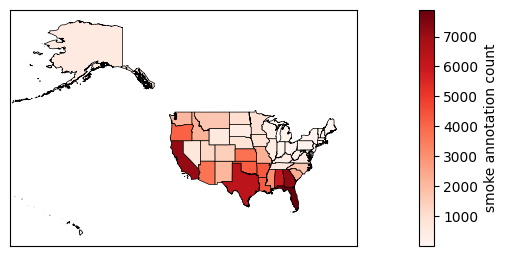

In [42]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
color = 'Reds'
fig, ax = plt.subplots(1, 1)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=-.1)
states.plot(column='smoke_count', cmap=color, edgecolor='black', linewidth=.5, ax=ax, legend=True, cax=cax, legend_kwds={'label': "smoke annotation count",'orientation': "vertical"})
ax.get_yaxis().set_visible(False)                                                                                                                        
ax.get_xaxis().set_visible(False)   
ax.set_xlim(-180,-60)
plt.show()
#ax.set_title('Count of Smoke Annotations')                                                                                            
#plt.savefig('figures/count_state_{}.png'.format(density), bbox_inches='tight')                                                                           
#plt.close()         

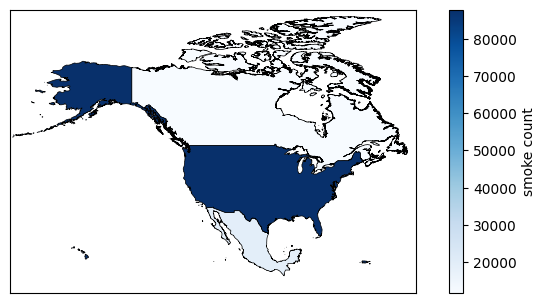

In [41]:
color = 'Blues'
fig, ax = plt.subplots(1, 1)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=-.1)
countries.plot(column='smoke_count', cmap=color, edgecolor='black', linewidth=.5, ax=ax, legend=True, cax=cax, legend_kwds={'label': "smoke count",'orientation': "vertical"})
ax.get_yaxis().set_visible(False)                                                                                                                        
ax.get_xaxis().set_visible(False)   
ax.set_xlim(-180,-50)
ax.set_ylim(10,85)

plt.show()